Persis Trial-5 tapi pola datanya baru

#### Import Library

In [3]:
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import requests
import matplotlib.pyplot as plt

#### N_step dan Nama Model Plot

In [1]:
# Konfigurasi Waktu dan unit_steps
n_steps = 8
modelLastDate = '27 Mar'
plotDate = '28-3 Apr'
modelName = 'T7_n'+str(n_steps)+'_' + modelLastDate + '.h5'
plotName = 'T7_n'+str(n_steps)+'_'+plotDate+'.jpg'
lossPlot = 'T7_loss_'+modelLastDate+'.jpg'

trainSinceLastWeek = 7
delta_day = trainSinceLastWeek*7+4 # Jatuh hari Kamis, untuk spare +1 di test_data

#### Mendapatkan Data dari API

In [4]:
# Data dari API
# url = 'https://iotlab-uns.com/smart-bms/public/api/daily-energy-reversed'
url = 'http://127.0.0.1:8000/api/daily-energy-reversed'
response = requests.get(url)
data = response.json()

data = pd.read_csv('data/real-1mei.csv', sep=';')

# Convert date strings to datetime objects
for record in data:
    record["date"] = datetime.strptime(record["date"], "%Y-%m-%d").date()
data

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /api/daily-energy-reversed (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000017BF028A4A0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

In [261]:
today = datetime.now().date()
last_sunday = today - timedelta(days=today.weekday() + delta_day)

filtered_data = []
for record in data:
    if record["date"] <= last_sunday:
        filtered_data.append(record)

filtered_data

[{'date': datetime.date(2024, 1, 1),
  'latest_updated': '2024-01-01 22:10:01',
  'energy_meter': 7420,
  'today_energy': 250},
 {'date': datetime.date(2024, 1, 2),
  'latest_updated': '2024-01-02 19:29:49',
  'energy_meter': 16350,
  'today_energy': 8930},
 {'date': datetime.date(2024, 1, 3),
  'latest_updated': '2024-01-03 23:53:46',
  'energy_meter': 27540,
  'today_energy': 11190},
 {'date': datetime.date(2024, 1, 4),
  'latest_updated': '2024-01-04 23:47:23',
  'energy_meter': 36720,
  'today_energy': 9180},
 {'date': datetime.date(2024, 1, 5),
  'latest_updated': '2024-01-05 23:56:40',
  'energy_meter': 49120,
  'today_energy': 12400},
 {'date': datetime.date(2024, 1, 6),
  'latest_updated': '2024-01-06 23:50:44',
  'energy_meter': 49340,
  'today_energy': 220},
 {'date': datetime.date(2024, 1, 7),
  'latest_updated': '2024-01-07 19:57:46',
  'energy_meter': 49550,
  'today_energy': 210},
 {'date': datetime.date(2024, 1, 8),
  'latest_updated': '2024-01-08 19:04:44',
  'energy_me

In [262]:
# Convert datetime objects back to date strings
for record in filtered_data:
    record["date"] = record["date"].strftime("%Y-%m-%d")
    
# Extract 'date' and 'today_energy' from JSON data
dates = [record['date'] for record in filtered_data]
energies = [record['today_energy'] for record in filtered_data]
print("energies : ", energies)
print("dates : ",dates)

energies :  [250, 8930, 11190, 9180, 12400, 220, 210, 240, 9040, 11340, 9270, 12770, 250, 220, 250, 9100, 10520, 9430, 10790, 250, 220, 260, 11190, 11890, 11450, 11970, 240, 210, 250, 9280, 12010, 9580, 13010, 250, 220, 220, 220, 240, 220, 210, 220, 220, 240, 9450, 12170, 9670, 13110, 250, 230, 240, 9720, 12280, 9710, 13120, 280, 240, 230, 9820, 12370, 9750, 13210, 260, 240, 210, 9920, 12420, 9800, 13110, 250, 220, 8360, 9810, 12140, 10040, 12900, 230, 220, 8480, 9910, 12170, 10010, 12910, 250, 220, 8510, 9900, 13450, 12150, 12630, 260, 220, 8470, 9880, 13070, 10280, 10660, 250, 220, 8210, 9520, 12500, 10070, 9890, 210, 220, 10110, 10460, 11710, 10340, 10220, 230, 210, 10110, 10410, 11520, 10500, 10200, 230, 240, 10030, 10550, 11600, 10320]
dates :  ['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16', '2024-01-17', '

#### Data Splitting

In [263]:
train_length = len(energies) - 8
test = energies[train_length:]

train_data = np.array(energies[:train_length]).reshape(-1,1)
test_data = np.array(test).reshape(-1,1)

# date_test = pd.to_datetime(dates[train_length:], format='%d/%m/%Y')
date_test = dates[train_length:]

print('Range test data : ',date_test)

Range test data :  ['2024-04-25', '2024-04-26', '2024-04-27', '2024-04-28', '2024-04-29', '2024-04-30', '2024-05-01', '2024-05-02']


#### Normalize the data

In [264]:
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)
# train_data_normalized
# test_data_normalized

In [265]:
# Prepare the data for LSTM
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [266]:
X_train, y_train = prepare_data(train_data_normalized, n_steps)
X_test, y_test = prepare_data(test_data_normalized, n_steps)

In [267]:
# Reshape the data for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


#### Make Model

In [268]:
model = Sequential()
model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

build = model.fit(X_train, y_train, epochs=200, verbose=2, validation_data=(X_test, y_test))
model.save('model/'+ modelName)
print(model.summary())

Epoch 1/200
4/4 - 10s - loss: 0.3901 - val_loss: 0.5425 - 10s/epoch - 3s/step
Epoch 2/200
4/4 - 0s - loss: 0.3599 - val_loss: 0.4949 - 193ms/epoch - 48ms/step
Epoch 3/200
4/4 - 0s - loss: 0.3290 - val_loss: 0.4313 - 185ms/epoch - 46ms/step
Epoch 4/200
4/4 - 0s - loss: 0.2883 - val_loss: 0.3408 - 249ms/epoch - 62ms/step
Epoch 5/200
4/4 - 0s - loss: 0.2303 - val_loss: 0.2053 - 188ms/epoch - 47ms/step
Epoch 6/200
4/4 - 0s - loss: 0.1544 - val_loss: 0.0275 - 165ms/epoch - 41ms/step
Epoch 7/200
4/4 - 0s - loss: 0.1611 - val_loss: 0.0104 - 211ms/epoch - 53ms/step
Epoch 8/200
4/4 - 0s - loss: 0.1419 - val_loss: 0.0731 - 273ms/epoch - 68ms/step
Epoch 9/200
4/4 - 0s - loss: 0.1426 - val_loss: 0.1115 - 195ms/epoch - 49ms/step
Epoch 10/200
4/4 - 0s - loss: 0.1435 - val_loss: 0.1041 - 221ms/epoch - 55ms/step
Epoch 11/200
4/4 - 0s - loss: 0.1435 - val_loss: 0.0688 - 174ms/epoch - 43ms/step
Epoch 12/200
4/4 - 0s - loss: 0.1349 - val_loss: 0.0383 - 165ms/epoch - 41ms/step
Epoch 13/200
4/4 - 0s - loss

e:\SMT 8\Trying\LSTM\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 7, 128)            66560     
                                                                 
 dropout_20 (Dropout)        (None, 7, 128)            0         
                                                                 
 lstm_31 (LSTM)              (None, 7, 64)             49408     
                                                                 
 dropout_21 (Dropout)        (None, 7, 64)             0         
                                                                 
 lstm_32 (LSTM)              (None, 16)                5184      
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 121169 (473.32 KB)
Trainable params: 12

#### Evaluate the Model

In [269]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=2)
test_loss = model.evaluate(X_test, y_test, verbose=0)

4/4 - 0s - loss: 0.0217 - 96ms/epoch - 24ms/step


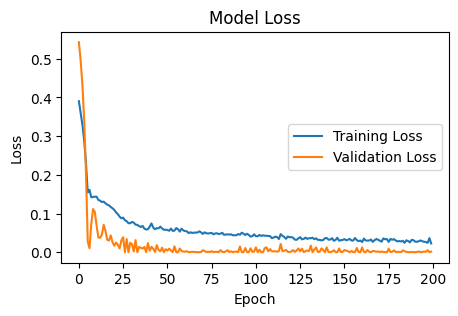

In [270]:
# Plot the training and validation loss
plt.figure(figsize=(5, 3))
plt.plot(build.history['loss'], label='Training Loss')
plt.plot(build.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(loc='center right')
plt.savefig('plot/'+lossPlot, bbox_inches='tight')
plt.show()

In [271]:
newTestData = test_data[:-1] # Menghapus hari ke-8 terakhir
newDateTest = date_test[:-1] 

#### Make Prediction

In [272]:
# Make predictions
predictions = []
current_batch = train_data_normalized[-n_steps:].reshape((1, n_steps, 1))

for i in range(len(newTestData)):
    current_pred = model.predict(current_batch)[0]
    predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

predictions

1/1 [==============================] - 0s 64ms/step


[array([0.79248613], dtype=float32),
 array([0.7393764], dtype=float32),
 array([-0.04868708], dtype=float32),
 array([0.03969752], dtype=float32),
 array([0.7371898], dtype=float32),
 array([0.76013017], dtype=float32),
 array([0.84177655], dtype=float32)]

In [273]:
# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)

In [274]:
for i in range (len(predictions)):
    if predictions[i] < 0:
        predictions[i] =+ 300.00
    elif predictions[i] < 2500:
        predictions[i] = 200+(10*i)

# Define a lambda function to format numbers with ',' as the decimal separator
custom_format = lambda x: f'{x:.8f}'.replace('.', ',')

# Convert the array to a string with ',' as the decimal separator
formatted_predictions = '\n'.join([','.join(map(lambda x: f'{x:.8f}'.replace('.', ','), row)) for row in predictions])

# Save the formatted predictions to a text file
with open('predictions.txt', 'w') as file:
    file.write(formatted_predictions)

In [275]:
# Prepare the results in JSON format
results = {
    'actual': newTestData.flatten().tolist(),
    'predicted': np.array(predictions).flatten().tolist()
}

results

{'actual': [10500, 10200, 230, 240, 10030, 10550, 11600],
 'predicted': [10702.516376972198,
  9999.343876838684,
  300.0,
  230.0,
  9970.393340587616,
  10274.123411178589,
  11355.121519565582]}

In [276]:
import json
# Convert the dictionary to JSON format
json_results = json.dumps(results, indent=4)

### Plotting Result

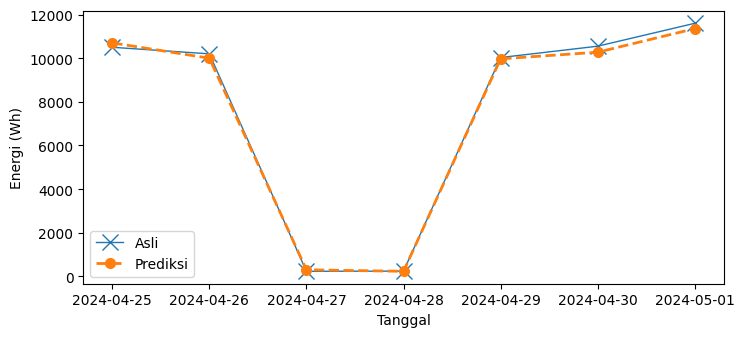

In [277]:
x,y = [21,9]

# Plot the results
plt.figure(figsize=(x/2.54, y/2.54))
plt.plot(newDateTest, newTestData.flatten(), label='Asli', linewidth=1, marker='x', markersize=12)
plt.plot(newDateTest, predictions, label='Prediksi', linewidth=2, linestyle='--', marker='.', markersize=14)
# plt.title('Realita vs Prediksi Energi Harian '+plotDate)
plt.xlabel('Tanggal')
plt.ylabel('Energi (Wh)')
plt.legend()
plt.savefig('plot/'+plotName, bbox_inches='tight')
plt.show()

In [278]:
# plt.figure(figsize=(12.8, 5.4))
# plt.plot(dates, energies, label='Asli', linewidth=1, marker='x', markersize=12)
# plt.plot(newDateTest, predictions, label='Prediksi', linewidth=2, linestyle='--', marker='.', markersize=14)
# plt.title('Realita vs Prediksi Energi Harian')
# plt.xlabel('Tanggal')
# plt.ylabel('Energi (Wh)')
# plt.legend()
# plt.show()

### Calculate Error

In [279]:
def calculate_mape(actual, predicted, epsilon=1e-10):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) using numpy
    
    :param actual: numpy array of actual values
    :param predicted: numpy array of predicted values
    :param epsilon (float): A small constant to avoid division by zero.
    :return: MAPE as a percentage
    """
    # Ensure actual and predicted arrays have the same length
    if actual.shape != predicted.shape:
        raise ValueError("Input arrays must have the same shape")
    
    # Ensure there are no zero values in the actual array
    if np.any(actual == 0):
        raise ValueError("Actual values must be non-zero")
    
    # Calculate MAPE using numpy
    mape = np.mean(np.abs((actual - predicted) / (actual + epsilon))) * 100
    return mape

def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

def calculate_mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))


In [280]:
mape = calculate_mape(newTestData, predictions)
rmse = calculate_rmse(newTestData, predictions)
mae = calculate_mae(newTestData, predictions)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")

MAE: 151.93
MAPE: 6.26%
RMSE: 179.64
